# Derivatives for expected improvement

## Sanity Checks
- Make sure we do newton iteration on the original problem

Throughout these notes, we consider the derivatives of the expected improvement function needed
for Newton's method and for differentiation of the argmax with respect to data and hyperparameters.
We write the expected improvement acquisition function as
$$\begin{aligned}
  \alpha(x) &= \sigma(x) g(z(x)) \\
  g(z) &= z \Phi(z) + \phi(z) \\
  z(x) &= \sigma(x)^{-1} \left[ \mu(x) - f^+ - \xi \right]
\end{aligned}$$
where $\Phi$ and $\phi$ denote the standard normal CDF and PDF, respectively; $f^+$ is the best function value
found so far; and $\xi$ is a parameter to encourage additional exploration.

Throughout this note, we will use the notation $f_{,i}$ to denote $\partial f / \partial x_i$, and $\dot{f}$ to denote
differentiation with respect to data or an arbitrary hyperparameter.  Except in this initial paragraph, we will 
generally suppress the parameter $x$, leaving it implicit.  Our goal is two-fold:

1.  We want to compute the derivatives necessary for Newton iteration on the problem of maximizing $\alpha$;
    that is, we want the gradient components $\alpha_{,i}$ and the Hessian components $\alpha_{,ij}$.
2.  Given $x^*$ such that $\alpha_{,i}(x^*) = 0$, we want to view $x^*$ as an implicit function of the
    data and input hyper-parameters, and compute derivatives of $x^*$ via implicit differentiation:
    $$
      \alpha_{,ij} \dot{x}_j^* + \dot{\alpha}_{,i} = 0.
    $$

We will structure the computation from the bottom up, first differentiating the kernel function,
then the predictive mean and variance, then $z$, and finally $\alpha$.

In [16]:
using Distributions
using LinearAlgebra
using Plots
using TaylorSeries

## Kernel derivatives

We assume the kernel has the form $k(x,y) = \psi(\rho)$ where $\rho = \|r\|$ and $r = x-y$.  Recall that
$$\begin{aligned}
  \rho &= \sqrt{r_k r_k} \\
  \rho_{,i} &= \rho^{-1} r_k r_{k,i} = \rho^{-1} r_i \\
  \rho_{,ij} &= \rho^{-1} \delta_{ij} - \rho^{-2} r_i \rho_{,j} \\
             &= \rho^{-1} \left[ \delta_{ij} - \rho^{-2} r_i r_j \right]
\end{aligned}$$
Applying this together with the chain rule yields
$$\begin{aligned}
  k &= \psi(\rho) \\
  k_{,i} &= \psi'(\rho) \rho_{,i} = \psi'(\rho) \rho^{-1} r_i \\
  k_{,ij} &= \psi''(\rho) \rho_{,i} \rho_{,j} + \psi'(\rho) \rho_{,ij} \\
          &= \left[ \psi''(\rho) - \rho^{-1} \psi'(\rho) \right] \rho^{-2} r_i r_j + \rho^{-1} \psi'(\rho) \delta_{ij}.
\end{aligned}$$

In [17]:
ψ(ρ; ℓ=1.0, σref=1.0) = σref*exp(-(ρ/ℓ)^2/2)
dψ(ρ; ℓ=1.0, σref=1.0) = ψ(ρ, ℓ=ℓ, σref=σref) * (-ρ/(ℓ^2))
d2ψ(ρ; ℓ=1.0, σref=1.0) = (1/ℓ^2)ψ(ρ, ℓ=ℓ, σref=σref) * (ρ^2/ℓ^2 - 1)

# Perturbations to hypers
δψ(ρ; ℓ=1.0, σref=1.0) = ψ(ρ, ℓ=ℓ, σref=σref) * (ρ^2/ℓ^3)
# δdψ(ρ; ℓ=1.0, σref=1.0) = ψ(ρ, ℓ=ℓ, σref=σref) * -ρ/ℓ^2 * ( ρ^2/ℓ^2 + 1 )
δdψ(ρ; ℓ=1.0, σref=1.0) = ψ(ρ, ℓ=ℓ, σref=σref)*(-ρ/ℓ^3) * (ρ^2/ℓ^2 - 2)

ρ = 1.23
h = 1e-4
fd_dψρ = ( ψ(ρ+h)-ψ(ρ-h) )/(2h)
fd_d2ψρ = ( ψ(ρ+h)-2*ψ(ρ)+ψ(ρ-h) )/h^2
relerr_dψρ = (dψ(ρ) - fd_dψρ)/dψ(ρ)
relerr_d2ψρ = (d2ψ(ρ) - fd_d2ψρ)/d2ψ(ρ)

println("Finite difference check on dψ:  $relerr_dψρ")
println("Finite difference check on d2ψ: $relerr_d2ψρ")

fd_δψ = (ψ(ρ; ℓ=1.01+h)-ψ(ρ; ℓ=1.01-h))/(2h)
fd_δdψ = (dψ(ρ; ℓ=1.01+h)-dψ(ρ; ℓ=1.01-h))/(2h)

println("Finite difference check on δψ: $( (δψ(ρ, ℓ=1.01)-fd_δψ)/δψ(ρ, ℓ=1.01) )")
println("Finite difference check on δdψ: $( (δdψ(ρ, ℓ=1.01)-fd_δdψ)/δdψ(ρ, ℓ=1.01) )")

Finite difference check on dψ:  2.4784095646792863e-9
Finite difference check on d2ψ: 1.5513488841753882e-8
Finite difference check on δψ: -1.3919287568289767e-9
Finite difference check on δdψ: 5.518101325186929e-8


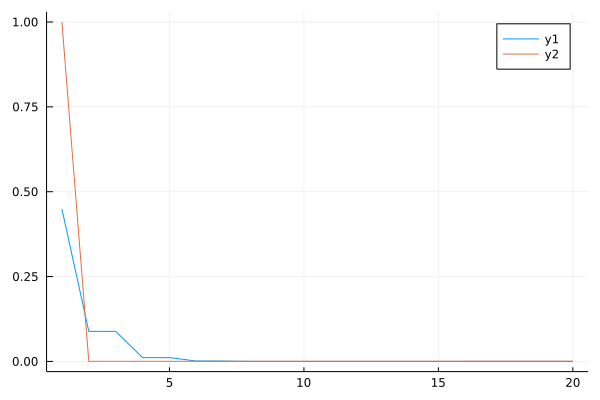

In [18]:
# Compute Exact Kernel, Compute Approximate Kernel, Plot Relative Error for Increasing Order of Accuracy
order = 20
errors = []
x = rand(4)
y = rand(4)
exact_kernel = k(x, y)
memory_used = []

for order in 1:order
    ρ = norm(x-y)
    memory = @allocated begin
        approx_kernel = taylor_expand(ψ, 0, order=order)(ρ)
    end
    relerr = abs(exact_kernel - approx_kernel) / exact_kernel
    push!(errors, relerr)
    push!(memory_used, memory)
end

# Normalize bytes used
memory_used /= maximum(memory_used)
plot(errors)
plot!(memory_used)

In [19]:
ρ = 0.
ψtaylor = taylor_expand(ψ, ρ, order=2)
derivative(ψtaylor)(ρ)

-0.0

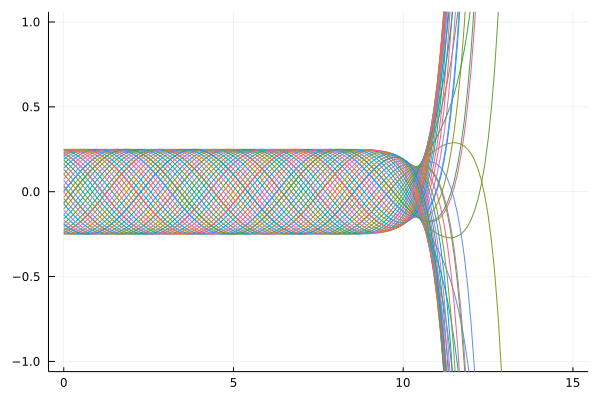

In [20]:
# x = zeros(2)
# y = [0, 1.23]
# ∇k(x, y)
f(ρ) = sin(ρ) * sin(ρ)
function g(ρ)
    return taylor_expand(sin, 0, order=16)(ρ) * sin(ρ)
end

dense_grid = 0:.1:15
plot(dense_grid, .25*taylor_expand(sin, 0, order=25).(dense_grid), ylims=[-1, 1])
for center in 1:50
    plot!(dense_grid, .25*taylor_expand(sin, center, order=25).(dense_grid), ylims=[-1, 1])
end
plot!(legend=false)
# (g(1.0) - f(1.0)) / f(1.0)

In [21]:
x1 = rand(4)
y1 = rand(4)
ρ1 = norm(x1-x1)
dψaug(ρ) = dψ(ρ) / ρ
∇k_approx = taylor_expand(dψaug)(ρ1)*(x1-x1)

4-element Array{Float64,1}:
 -0.0
 -0.0
 -0.0
 -0.0

In [22]:
# norm(∇k(x1, y1) - ∇k_approx) / norm(∇k(x1, y1))
Hk(x1, x1)

Hessian k


4×4 Array{Float64,2}:
 -1.0   0.0   0.0   0.0
  0.0  -1.0   0.0   0.0
  0.0   0.0  -1.0   0.0
  0.0   0.0   0.0  -1.0

In [32]:
k(x, y; ℓ=1.0, σref=1.0) = ψ(norm(x-y), ℓ=ℓ, σref=σref)

function ∇k(x, y; ℓ=1.0, σref=1.0)
    ρ = norm(x-y)
    if ρ ≈ 0
        # Compute the taylor expansion of ψ about zero then compute it's derivative
        dψtaylor = taylor_expand(ρ -> dψ(ρ, ℓ=ℓ, σref=σref) / ρ, 0, order=2)(ρ) * (x-y)
        return dψtaylor
    end
    return dψ(ρ, ℓ=ℓ, σref=σref) * (x-y)/ρ
end

function Hk(x, y; ℓ=1.0, σref=1.0)
    r = x-y
    ρ = norm(r)
    if ρ ≈ 0
        dψtaylor1 = taylor_expand(ρ -> (d2ψ(ρ, ℓ=ℓ, σref=σref) - dψ(ρ, ℓ=ℓ, σref=σref)/ρ)/ρ^2, 0, order=2)(ρ)
        dψtaylor2 = taylor_expand(ρ -> dψ(ρ, ℓ=ℓ, σref=σref) / ρ, 0, order=2)(ρ)
        return dψtaylor1 * r * r' + dψtaylor2 * I
    end
    return (d2ψ(ρ) - dψ(ρ)/ρ)/ρ^2 * r * r' + dψ(ρ)/ρ * I
end

δk(x, y; ℓ=1.0, σref=1.0) = δψ(norm(x-y), ℓ=ℓ, σref=σref)

function δ∇k(x, y; ℓ=1.0, σref=1.0)
    ρ = norm(x-y)
    return δdψ(ρ, ℓ=ℓ, σref=σref) * (x-y)/ρ
end

x = rand(7)
y = rand(7)
u = rand(7)

dk_du = ∇k(x, y)'*u
fd_dk_du = (k(x+h*u, y)-k(x-h*u, y))/(2h)
println("Check on derivative: $( (dk_du-fd_dk_du)/dk_du )")

d2k_du2 = u'*Hk(x, y)*u
fd_d2k_du2 = ( k(x+h*u, y)-2*k(x, y)+k(x-h*u, y) )/h^2
alt_fd_d2k_du2 = ( k(x-2h*u, y) + 4k(x-h*u, y) - 10k(x, y) + 4k(x+h*u, y) + k(x+2h*u, y) ) / 8h^2
println("Check second derivative: $( (d2k_du2-fd_d2k_du2)/d2k_du2 )")
println("Check second derivative (higher-order approx): $(( d2k_du2-alt_fd_d2k_du2) / d2k_du2)")
println("Absolute Difference: $(abs(alt_fd_d2k_du2 - fd_d2k_du2))")

Check on derivative: 1.6873086335627967e-8
Check second derivative: 1.0382718642825378e-8
Check second derivative (higher-order approx): 2.6062862115156203e-8
Absolute Difference: 4.440892098500626e-8


## Mean derivatives

Let $K_{XX}$ denote the kernel matrix, and $k_{Xx}$ the column vector of kernel evaluations at $x$.
The posterior mean function for the GP (assuming a zero-mean prior) is
$$
  \mu = k_{xX} c
$$
where $K_{XX} c = y$.  Note that $c$ does not depend on $x$, but it does depend on the data and hyperparameters.

Differentiating in space is straightforward, as we only invoke the kernel derivatives:
$$\begin{aligned}
  \mu_{,i} &= k_{xX,i} c \\
  \mu_{,ij} &= k_{xX,ij} c
\end{aligned}$$
Differentiating in the data and hyperparameters requires that we also differentiate through a matrix solve:
$$
  \dot{\mu} = \dot{k}_{xX} K_{XX}^{-1} y + k_{xX} K_{XX}^{-1} \dot{y} - k_{xX} K_{XX}^{-1} \dot{K}_{XX} K_{XX}^{-1} y.
$$
Defining $d = K_{XX}^{-1} k_{Xx}$, we have
$$
  \dot{\mu} = \dot{k}_{xX} c + d^T (\dot{y} - \dot{K}_{XX} c).
$$
Now differentiating in space and defining $K_{XX}^{-1} k_{Xx,i}$ as $w^{(i)}$, we have
$$
  \dot{\mu}_{,i} = \dot{k}_{xX,i} c + (w^{(i)})^T (\dot{y} - \dot{K}_{XX} c).
$$

### Darian's Question
Why is $(\dot{y} - \dot{K}_{XX} c)$ treated as a constant when differentiating in space? Don't these values depend on the spatial coordinates as well? Similarly, for $c$.

In [33]:
function kernel_matrix(X, Y; ℓ=1.0, σref=1.0)
    n = size(X)[2]
    m = size(Y)[2]
    K = zeros(n, m)
    for i = 1:n
        for j = 1:m
            K[i,j] = k(X[:,i], Y[:,j], ℓ=ℓ, σref=σref)
        end
    end
    return K
end

function μ(x, X, c; ℓ=1.0, σref=1.0)
    μx = 0.0
    for i = 1:size(X)[2]
        μx += c[i] * k(x, X[:,i], ℓ=ℓ, σref=σref)
    end
    return μx
end

function ∇μ(x, X, c; ℓ=1.0, σref=1.0)
    ∇μx = zeros(length(x))
    for i = 1:size(X)[2]
        ∇μx += c[i] * ∇k(x, X[:,i], ℓ=ℓ, σref=σref)
    end
    return ∇μx
end

function Hμ(x, X, c; ℓ=1.0, σref=1.0)
    Hμx = zeros(length(x), length(x))
    for i = 1:size(X)[2]
        Hμx += c[i] * Hk(x, X[:,i], ℓ=ℓ, σref=σref)
    end
    return Hμx
end

# Set up a test problem

X = rand(3, 10)
y = X[1,:] + 2*X[2,:] + 4*X[3,:]
KXX = kernel_matrix(X, X, ℓ=1.0, σref=1.0)
c = KXX\y

x = rand(3)
println("μ($x) = $(μ(x, X, c)) ≈ $(x[1] + 2*x[2] + 4*x[3])")
println("∇μ($x) = $(∇μ(x, X, c)) ≈ [1, 2, 4]")
println("Hμ($x) = $(Hμ(x, X, c)) ≈ 0 matrix")

u = rand(3)
d2μ_du2 = u'*Hμ(x, X, c)*u
fd_d2μ_du2 = (μ(x+2h*u, X, c) - 2μ(x, X, c) + μ(x-2h*u, X, c)) / 4h^2
relerr_Hμ = (d2μ_du2 - fd_d2μ_du2) / d2μ_du2
println("Finite difference check on Hμ: $(relerr_Hμ)")

# Finite difference check for Hμ
fd_∇μ_du = u'*( ∇μ(x+h*u, X, c) - ∇μ(x-h*u, X, c) ) / (2h)
relerr_Hμ = (d2μ_du2 - fd_∇μ_du) / d2μ_du2
println("Finite difference checn on Hμ again: $(relerr_Hμ)")

μ([0.7533754657261373, 0.8609000170057801, 0.17258666839925407]) = 2.7812576848332533 ≈ 3.165522173334714
∇μ([0.7533754657261373, 0.8609000170057801, 0.17258666839925407]) = [0.5078451011151941, 0.33862664305383117, 4.213543514249328] ≈ [1, 2, 4]
Hμ([0.7533754657261373, 0.8609000170057801, 0.17258666839925407]) = [-0.5254497765485802 -1.7669493604458946 -0.10934846829980449; -1.7669493604458937 -3.1474609299047067 -0.6755164491325969; -0.10934846829980494 -0.6755164491325969 1.33985595882071] ≈ 0 matrix
Finite difference check on Hμ: 1.813758362361408e-6
Finite difference checn on Hμ again: -1.4041356403540523e-8


In [34]:
# δk = dk/dl * l̇
function δμ(x, X, c, ẏ, l̇; ℓ=1.0, σref=1.0)
    δμx = 0.0
    KXX = kernel_matrix(X, X)
    KXx = kernel_matrix(X, reshape(x, length(x), 1))
    d = KXX \ KXx
    
    for i = 1:size(X)[2]
        δμx += c[i] * δk(x, X[:, i]) * l̇ + d[i]*ẏ[i]
        for j = 1:size(X)[2]
            δμx -= d[i] * δk(X[:, i], X[:, j]) * l̇ * c[j] 
        end
    end
    
    return δμx
end

function δ∇μ(x, X, c, ẏ, l̇; ℓ=1.0, σref=1.0)
    δ∇μx = zeros(length(x))
    W = zeros(size(X))
    
    for ndx = 1:size(X)[2]
        W[:, ndx] = ∇k(x, X[:, ndx])
        δ∇μx += δ∇k(x, X[:, ndx]) * c[ndx] * l̇
    end
    
    W /= kernel_matrix(X, X, ℓ=ℓ, σref=σref)
    z = copy(ẏ)
    
    for i = 1:size(X)[2]
        for j = 1:size(X)[2]
            z[i] -= δk(X[:, i], X[:, j]) * l̇ * c[j]
        end
    end
    
    δ∇μx += W*z
    
    return δ∇μx
end

l̇ = rand()
ẏ = rand(length(c))
c = kernel_matrix(X, X, ℓ=1.0) \ y
cplus = kernel_matrix(X, X, ℓ=1.0+h*l̇) \ (y + h*ẏ)
cminus = kernel_matrix(X, X, ℓ=1.0-h*l̇) \ (y - h*ẏ)

δμ_test = δμ(x, X, c, ẏ, l̇)
fd_δμ = ( μ(x, X, cplus, ℓ=1.0+h*l̇) - μ(x, X, cminus, ℓ=1.0-h*l̇) ) / (2h)
relerr = (δμ_test - fd_δμ) / δμ_test
println("Fininte difference check for δμ: $relerr")

# Finite difference on δμ
u = rand(length(x))
δ∇μ_test = u'*δ∇μ(x, X, c, ẏ, l̇)
fd_δ∇μ = ( δμ(x+h*u, X, c, ẏ, l̇) - δμ(x-h*u, X, c, ẏ, l̇) ) / (2h)
relerr = (δ∇μ_test - fd_δ∇μ) / δ∇μ_test 
println("Fininte difference check for δ∇μ: $relerr")

Fininte difference check for δμ: 1.833691116471325e-10
Fininte difference check for δ∇μ: 8.841238504118034e-9


## Standard deviation derivatives

The predictive variance is
$$
  \sigma^2 = k_{xx} - k_{xX} K_{XX}^{-1} k_{Xx}.
$$
Differentiating the predictive variance twice in space --- assuming $k_{xx}$ is independent of $x$ by stationarity ---
gives us
$$\begin{aligned}
  2 \sigma \sigma_{,i} &= -2 k_{xX,i} K_{XX}^{-1} k_{Xx} = -2 k_{xX,i} d \\
  2 \sigma_{,i} \sigma_{,j} + 2 \sigma \sigma_{,ij} &= -2 k_{xX,ij} K_{XX}^{-1} k_{Xx} - 2 k_{xX,i} K_{XX}^{-1} k_{Xx,j} \\
                     &= -2 k_{xX,ij} d -2 k_{xX,i} w^{(j)}
\end{aligned}$$
Rearranging to get spatial derivatives of $\sigma$ on their own gives us
$$\begin{aligned}
  \sigma_{,i} &= -\sigma^{-1} k_{xX,i} d \\
  \sigma_{,ij} &= -\sigma^{-1} \left[ k_{xX,ij} d + k_{xX,i} w^{(j)} + \sigma_{,i} \sigma_{,j} \right].
\end{aligned}$$

Differentiating with respect to data (and locations) and kernel hypers requires more work.  First, note that
$$\begin{aligned}
  2 \sigma \dot{\sigma} 
  &= \dot{k}_{xx} - 2 \dot{k}_{xX} K_{XX}^{-1} k_{Xx} + k_{xX} K_{XX}^{-1} \dot{K}_{XX} K_{XX}^{-1} k_{Xx} \\
  &= \dot{k}_{xx} - 2 \dot{k}_{xX} d + d^T \dot{K}_{XX} d
\end{aligned}$$
Now, differentiating $\sigma^{-1}$ with respect to data and hypers gives
$$\begin{aligned}
  \dot{\sigma}_{,i} 
  &= \sigma^{-2} \dot{\sigma} k_{xX,i} K_{XX}^{-1} k_{Xx} -
     \sigma^{-1} \left[ 
       \dot{k}_{xX,i} K_{XX}^{-1} k_{Xx} +
       k_{xX,i} K_{XX}^{-1} \dot{k}_{Xx} -
       k_{xX} K_{XX}^{-1} \dot{K}_{XX} K_{XX}^{-1} k_{Xx} \right] \\
  &= -\sigma^{-1} \left[ \dot{\sigma} \sigma_{,i} + \dot{k}_{xX,i} d + (w^{(i)})^T \dot{k}_{Xx} - d^T \dot{K}_{XX} d \right]
\end{aligned}$$

My results when differentiating $\sigma^{-1}$ with respect to data and hypers gives
$$\begin{aligned}
  \dot{\sigma}_{,i} &= -\sigma^{-1} \left[ \dot{\sigma} \sigma_{,i} -
                       (w^{(i)})^T \dot{K}_{XX} d + (w^{(i)})^T \dot{k}_{Xx} + \dot{K}_{xX,i}d
  \right]
\end{aligned}$$

In [35]:
function Hσ(x, X; ℓ=1.0, σref=1.0)
    Hσx = zeros(length(x), length(x))
    KXx = kernel_matrix(X, reshape(x, length(x), 1))
    d = kernel_matrix(X, X) \ KXx
    
    W = zeros(size(X))
    for col = 1:size(W)[2]
       W[:, col] = ∇k(x, X[:, col]) 
    end
    W /= kernel_matrix(X, X, ℓ=ℓ, σref=σref)
    
    for i = 1:size(X)[2]
        Hσx += Hk(x, X[:, i])*d[i] + ∇k(x, X[:, i])*W[:, i]'
    end
    
    Hσx += ∇σ(x, X)*∇σ(x, X)'
    Hσx ./= -σ(x, X)
    
    return Hσx
end

function δ∇σ(x, X, l̇; ℓ=1.0, σref=1.0)
    δ∇σx = δσ(x, X, l̇) * ∇σ(x, X)
    KXX = kernel_matrix(X, X)
    KXx = kernel_matrix(X, reshape(x, length(x), 1))
    d = KXX \ KXx
    
    W = zeros(size(X))
    for ndx = 1:size(X)[2]
        W[:, ndx] = ∇k(x, X[:, ndx])
    end
    W /= kernel_matrix(X, X, ℓ=ℓ, σref=σref)
    
    z0 = zeros(length(x))
    z1 = zeros(size(X)[2])
    z2 = zeros(size(X)[2])
    
    for i = 1:size(X)[2]
        z0 += δ∇k(x, X[:, i]) * d[i] * l̇
        z2[i] = δk(x, X[:, i]) * l̇
        for j = 1:size(X)[2]
            z1[i] += δk(X[:, i], X[:, j]) * d[j] * l̇
        end
    end
    
    δ∇σx += -W*z1 + W*z2 + z0
    δ∇σx /= -σ(x, X)

    return δ∇σx
end

function δσ(x, X, l̇; ℓ=1.0, σref=1.0)
    δσx = δk(x, x) * l̇
    KXX = kernel_matrix(X, X)
    KXx = kernel_matrix(X, reshape(x, length(x), 1))
    d = KXX \ KXx
    
    for i = 1:size(X)[2]
        δσx -= 2δk(x, X[:, i]) * d[i] * l̇
        for j = 1:size(X)[2]
            δσx += d[i] * d[j] * δk(X[:, i], X[:, j]) * l̇
        end
    end
    
    δσx /= 2σ(x, X)
    return δσx
end

function σ(x, X; ℓ=1.0, σref=1.0)
    KXX = kernel_matrix(X, X, ℓ=ℓ, σref=σref)
    KXx = kernel_matrix(X, reshape(x, length(x), 1), ℓ=ℓ, σref=σref)
    return √(k(x, x) - dot(KXx, KXX \ KXx))
end

function ∇σ(x, X; ℓ=1.0, σref=1.0)
    ∇σx = zeros(length(x))
    KXx = kernel_matrix(X, reshape(x, length(x), 1))
    d = kernel_matrix(X, X) \ KXx
    
    for i = 1:size(X)[2]
        ∇σx += d[i] * ∇k(x, X[:, i], ℓ=ℓ, σref=σref)
    end
    
    ∇σx /= -σ(x, X, ℓ=ℓ, σref=σref)
    
    return ∇σx
end

# Finite difference check on σ wrt to spatial coordinates
u = rand(length(x))
∇σ_test = u'*∇σ(x, X)
fd_dσ_du = ( σ(x+h*u, X) - σ(x-h*u, X) ) / (2h)
relerr = (∇σ_test - fd_dσ_du) / ∇σ_test
println("Finite difference check on ∇σ: $relerr")

# Finite difference check (of hessian) on σ wrt to spatial coordinates
u = rand(length(x))
Hσ_test = u'*Hσ(x, X)*u
fd_d2σ_du2 = ( σ(x+2h*u, X) - 2σ(x, X) + σ(x-2h*u, X) ) / (4h^2)
relerr = (Hσ_test - fd_d2σ_du2) / Hσ_test
println("Finite difference check on Hσ: $relerr")

# Finite difference check (of hessian) against gradient
fd_∇σ_du = u' * ( ∇σ(x+h*u, X) - ∇σ(x-h*u, X) ) / (2h)
relerr = (Hσ_test - fd_∇σ_du) / Hσ_test
println("Finite difference check on Hσ again: $relerr")

# Finite difference check wrt to hypers
l̇ = rand()
δσ_test = δσ(x, X, l̇)
fd_δσ_dl = ( σ(x, X; ℓ=1.0+h*l̇) - σ(x, X; ℓ=1.0-h*l̇) ) / (2h)
relerr = (δσ_test - fd_δσ_dl) / δσ_test
println("Finite difference check on δσ: $relerr")

# Finite difference check on δσ
l̇ = rand()
u = rand(length(x))
δ∇σ_test = dot(u, δ∇σ(x, X, l̇))
fd_δ∇σ_dx = ( δσ(x+h*u, X, l̇) - δσ(x-h*u, X, l̇) ) / (2h)
relerr = (δ∇σ_test - fd_δ∇σ_dx) / δ∇σ_test
println("Finite difference check on δ∇σ: $relerr")

Finite difference check on ∇σ: 6.290846948432381e-9
Finite difference check on Hσ: 1.6009737169577723e-6
Finite difference check on Hσ again: 8.042663639642017e-8
Finite difference check on δσ: -1.0297273033035624e-9
Finite difference check on δ∇σ: 6.127467131713824e-9


## Differentiating $z$

Now consider $z = \sigma^{-1} [\mu - f^+ - \xi]$.  As before, we begin with spatial derivatives:
$$\begin{aligned}
  z_{,i} &= -\sigma^{-2} \sigma_{,i} [\mu - f^+ - \xi] + \sigma^{-1} \mu_{,i} \\
         &= \sigma^{-1} \left[ \mu_{,i} - \sigma_{,i} z \right] \\
  z_{,ij} &= -\sigma^{-2} \sigma_{,j} \left[ \mu_{,i} - \sigma_{,i} z \right] + 
             \sigma^{-1} \left[\mu_{,ij} - \sigma_{,ij} z - \sigma_{,i} z_{,j} \right] \\
          &= \sigma^{-1} \left[ \mu_{,ij} - \sigma_{,ij} z - \sigma_{,i} z_{,j} - \sigma_{,j} z_{,i} \right]
\end{aligned}$$
Now we differentiate with respect to data and hypers:
$$\begin{aligned}
  \dot{z} &= -\sigma^{-2} \dot{\sigma} [\mu - f^+ - \xi] + \sigma^{-1} [\dot{\mu} - \dot{f}^+ - \dot{\xi}] \\
          &= \sigma^{-1} [\dot{\mu} - \dot{f}^+ - \dot{\xi} - \dot{\sigma} z] \\
  \dot{z}_{,i} &= \sigma^{-1} [\dot{\mu}_{,i} -\dot{\sigma}_{,i} z - \dot{\sigma} z_{,i} -\sigma_{,i} \dot{z}]
\end{aligned}$$

In [36]:
z(x, X, c, f⁺, ξ; ℓ=1.0, σref=1.0) = (1/σ(x, X, ℓ=ℓ, σref=σref)) * (μ(x, X, c, ℓ=ℓ, σref=σref) - f⁺ - ξ)
∇z(x, X, c, f⁺, ξ; ℓ=1.0, σref=1.0) = (1/σ(x, X, ℓ=ℓ, σref=σref)) * (∇μ(x, X, c, ℓ=ℓ, σref=σref) - ∇σ(x, X, ℓ=ℓ, σref=σref)
    * z(x, X, c, f⁺, ξ, ℓ=ℓ, σref=σref)
)
Hz(x, X, c, f⁺, ξ; ℓ=1.0, σref=1.0) = (1/σ(x, X, ℓ=ℓ, σref=σref)) * (
    Hμ(x, X, c, ℓ=ℓ, σref=σref) - Hσ(x, X, ℓ=ℓ, σref=σref)*z(x, X, c, f⁺, ξ, ℓ=ℓ, σref=σref) - 
    ∇σ(x, X, ℓ=ℓ, σref=σref)*∇z(x, X, c, f⁺, ξ, ℓ=ℓ, σref=σref)' - (∇z(x, X, c, f⁺, ξ, ℓ=ℓ, σref=σref)*∇σ(x, X, ℓ=ℓ, σref=σref)')
)
δz(x, X, c, f⁺, ξ, l̇, ẏ; ḟ⁺=0.0, ξ̇=0.0, ℓ=1.0, σref=1.0) = (1/σ(x, X, ℓ=ℓ, σref=σref)) * (
    δμ(x, X, c, ẏ, l̇, ℓ=ℓ, σref=σref) - ḟ⁺ - ξ̇ - δσ(x, X, l̇, ℓ=ℓ, σref=σref)*z(x, X, c, f⁺, ξ, ℓ=ℓ, σref=σref)
)
δ∇z(x, X, c, f⁺, ξ, l̇, ẏ; ḟ⁺=0.0, ξ̇=0.0, ℓ=1.0, σref=1.0) = (1/σ(x, X, ℓ=ℓ, σref=σref)) * (
    δ∇μ(x, X, c, ẏ, l̇, ℓ=ℓ, σref=σref) - δ∇σ(x, X, l̇, ℓ=ℓ, σref=σref)*z(x, X, c, f⁺, ξ, ℓ=ℓ, σref=σref) -
    δσ(x, X, l̇, ℓ=ℓ, σref=σref)*∇z(x, X, c, f⁺, ξ, ℓ=ℓ, σref=σref) - ∇σ(x, X, ℓ=ℓ, σref=σref)*δz(x, X, c, f⁺, ξ, l̇, ẏ, ḟ⁺=ḟ⁺, ξ̇=ξ̇, ℓ=ℓ, σref=σref)
)

# Finite difference check for ∇z
u = rand(length(x))
f⁺, ξ = [0.0, 0.0]
∇z_test = dot(u, ∇z(x, X, c, f⁺, ξ))
fd_dz_dx = ( z(x+h*u, X, c, f⁺, ξ) - z(x-h*u, X, c, f⁺, ξ) ) / (2h)
relerr = (∇z_test - fd_dz_dx) / ∇z_test
println("Finite difference check for ∇z: $relerr")

# Finite difference check for Hz
# Hz_test = u'*Hz(x, X, c, f⁺, ξ)*u
# fd_d2z_dx2 = ( z(x+2h*u, X, c, f⁺, ξ) - 2z(x, X, c, f⁺, ξ) + z(x-2h*u, X, c, f⁺, ξ) ) / (4h^2)
# relerr = (Hz_test - fd_d2z_dx2) / Hz_test
# println("Finite difference check for Hz: $relerr")

# Finite difference check for Hz using ∇z
Hz_test = u'*Hz(x, X, c, f⁺, ξ)*u
fd_∇z_du = u' * ( ∇z(x+h*u, X, c, f⁺, ξ) - ∇z(x-h*u, X, c, f⁺, ξ) ) / (2h)
relerr = (Hz_test - fd_∇z_du) / Hz_test
println("Finite difference check for Hz again: $relerr")

# Finite difference check for δz
l̇ = rand()
ẏ = rand(length(y))
cplus = kernel_matrix(X, X, ℓ=1.0+h*l̇) \ (y + h*ẏ)
cminus = kernel_matrix(X, X, ℓ=1.0-h*l̇) \ (y - h*ẏ)
δz_test = δz(x, X, c, f⁺, ξ, l̇, ẏ)
fd_dz_dl = ( z(x, X, cplus, f⁺, ξ, ℓ=1.0+h*l̇) - z(x, X, cminus, f⁺, ξ, ℓ=1.0-h*l̇) ) / (2h)
relerr = (δz_test - fd_dz_dl) / δz_test
println("Finite difference check for δz: $relerr")

# Finite difference check for mixed derivative δ∇z
δ∇z_test = u' * δ∇z(x, X, c, f⁺, ξ, l̇, ẏ)
# fd_∇z_dl = u' * ( ∇z(x, X, cplus, f⁺, ξ, ℓ=1.0+h*l̇) - ∇z(x, X, cminus, f⁺, ξ, ℓ=1.0-h*l̇) ) / (2h)
fd_δz_dx = ( δz(x+h*u, X, c, f⁺, ξ, l̇, ẏ) - δz(x-h*u, X, c, f⁺, ξ, l̇, ẏ) ) / (2h)
# relerr = (δ∇z_test - fd_∇z_dl) / δ∇z_test
orelerr = (δ∇z_test - fd_δz_dx) / δ∇z_test
# println("Finite difference check for δ∇z: $relerr")
println("Finite difference check for δ∇z: $orelerr")

Finite difference check for ∇z: -9.436084684972916e-9
Finite difference check for Hz again: -7.284107852164538e-9
Finite difference check for δz: 7.63061491055747e-9
Finite difference check for δ∇z: -1.0921472358425061e-8


## Differentiating $\alpha$

Finally, we differentiate $\alpha = \sigma g(z)$.  As before, we start with spatial derivatives:
$$\begin{aligned}
  \alpha_{,i} &= \sigma_{,i} g(z) + \sigma g'(z) z_{,i} \\
  \alpha_{,ij} &= \sigma_{,ij} g(z) + \sigma_{,i} g'(z) z_{,j} + \sigma_{,j} g'(z) z_{,i} + \sigma g'(z) z_{,ij} + \sigma g''(z) z_{,i} z_{,j} \\
  &= \sigma_{,ij} g(z) + [\sigma_{,i} z_{,j} + \sigma_{,j} z_{,i} + \sigma z_{,ij}] g'(z) + \sigma g''(z) z_{,i} z_{,j}
\end{aligned}$$
We also may want the mixed derivative with respect to spatial coordinates and data and hypers:
$$\begin{aligned}
  \dot{\alpha}_{,i} &= \dot{\sigma}_{,i} g(z) + \sigma_{,i} g'(z) \dot{z} + \dot{\sigma} g'(z) z_{,i} + \sigma g''(z) \dot{z} z_{,i} + \sigma g'(z) \dot{z}_{,i}
\end{aligned}$$

Finally, we differentiate $g(z) = z \Phi(z) + \phi(z)$, noting that
$\phi'(z) = -z \phi(z)$ and $\Phi'(z) = \phi(z)$.  This gives
$$\begin{aligned}
  g(z) &= z \Phi(z) + \phi(z) \\
  g'(z) &= \Phi(z) + z \phi(z) + \phi'(z) = \Phi(z) \\
  g''(z) &= \phi(z).
\end{aligned}$$


In [37]:
g(z) = z * cdf(Normal(), z) + pdf(Normal(), z)
dg(z) = cdf(Normal(), z)
d2g(z) = pdf(Normal(), z)

# Finite difference check of g
z0 = z(x, X, c, f⁺, ξ; ℓ=1.0, σref=1.0)
dg_test = dg(z0)
fd_dg_dz = ( g(z0+h) - g(z0-h) ) / (2h)
relerr = (dg_test - fd_dg_dz) / dg_test
println("Finite difference check for g: $relerr")

z0 = 0.1
d2g_test = d2g(z0)
fd_d2g_dz2 = ( dg(z0+h) - dg(z0-h) ) / (2h)
relerr = (d2g_test - fd_d2g_dz2) / d2g_test
println("Finite difference check for dg: $relerr")

Finite difference check for g: 2.3305801732931286e-12
Finite difference check for dg: 1.6494457623861254e-9


In [41]:
function δ∇α(x, X, c, f⁺, ξ, l̇, ẏ; ḟ⁺=0.0, ξ̇=0.0, ℓ=1.0, σref=1.0)
    z0 = z(x, X, c, f⁺, ξ; ℓ=ℓ, σref=σref)
    gprime = dg(z0)
    ∇zx = ∇z(x, X, c, f⁺, ξ; ℓ=ℓ, σref=σref)
    δzx = δz(x, X, c, f⁺, ξ, l̇, ẏ, ḟ⁺=ḟ⁺, ξ̇=ξ̇, ℓ=ℓ, σref=σref)
    σx = σ(x, X, ℓ=ℓ, σref=σref)
    
    return δ∇σ(x, X, l̇, ℓ=ℓ, σref=σref)*g(z0) + ∇σ(x, X, ℓ=ℓ, σref=σref)*gprime*δzx +
    δσ(x, X, l̇, ℓ=ℓ, σref=σref)*gprime*∇zx + σx*d2g(z0)*δzx*∇zx + σx*gprime*δ∇z(x, X, c, f⁺, ξ, l̇, ẏ, ḟ⁺=ḟ⁺, ξ̇=ξ̇, ℓ=ℓ, σref=σref)
end

α(x, X, c, f⁺, ξ; ℓ=1.0, σref=1.0) = σ(x, X) * g(z(x, X, c, f⁺, ξ; ℓ=1.0, σref=1.0))

function ∇α(x, X, c, f⁺, ξ; ℓ=1.0, σref=1.0)
    z0 = z(x, X, c, f⁺, ξ; ℓ=ℓ, σref=σref)
    return ∇σ(x, X, ℓ=ℓ, σref=σref)*z0 + σ(x, X, ℓ=ℓ, σref=σref)*dg(z0)*∇z(x, X, c, f⁺, ξ; ℓ=ℓ, σref=σref)
end

function Hα(x, X, c, f⁺, ξ; ℓ=1.0, σref=1.0)
    z0 = z(x, X, c, f⁺, ξ; ℓ=ℓ, σref=σref)
    ∇zx = ∇z(x, X, c, f⁺, ξ, ℓ=ℓ, σref=σref)
    ∇σx = ∇σ(x, X, ℓ=ℓ, σref=σref)
    σx = σ(x, X, ℓ=ℓ, σref=σref)
    Hzx = Hz(x, X, c, f⁺, ξ; ℓ=ℓ, σref=σref)
    
    return Hσ(x, X, ℓ=ℓ, σref=σref)*g(z0) + (∇σx*∇zx' + ∇zx*∇σx' + σx * Hzx)*dg(z0) + σx*d2g(z0)*∇zx*∇zx'
end

# Finite difference check of ∇α
u = rand(length(x))
∇α_test = dot(u, ∇α(x, X, c, f⁺, ξ, ℓ=1.0, σref=1.0))
fd_dα_dx = ( α(x+h*u, X, c, f⁺, ξ; ℓ=1.0, σref=1.0) - α(x-h*u, X, c, f⁺, ξ; ℓ=1.0, σref=1.0) ) / (2h)
relerr = (∇α_test - fd_dα_dx) / ∇α_test
println("Finite difference check for ∇α: $relerr")

# Finite difference check of Hα
Hα_test = dot(u, u'*Hα(x, X, c, f⁺, ξ, ℓ=1.0, σref=1.0))
fd_d2α_dx2 = u' * ( ∇α(x+h*u, X, c, f⁺, ξ; ℓ=1.0, σref=1.0) - ∇α(x-h*u, X, c, f⁺, ξ; ℓ=1.0, σref=1.0) ) / (2h)
relerr = (Hα_test - fd_d2α_dx2) / Hα_test
println("Finite difference check for Hα: $relerr")

# Finite difference check for δ∇α
l̇ = rand()
ẏ = rand(length(y))
cplus = kernel_matrix(X, X, ℓ=1.0+h*l̇) \ (y + h*ẏ)
cminus = kernel_matrix(X, X, ℓ=1.0-h*l̇) \ (y - h*ẏ)
δ∇α_test = u' * δ∇α(x, X, c, f⁺, ξ, l̇, ẏ, ḟ⁺=0.0, ξ̇=0.0, ℓ=1.0, σref=1.0)
fd_∇α_dl = u' * ( ∇α(x, X, cplus, f⁺, ξ; ℓ=1.0+h*l̇, σref=1.0) - ∇α(x, X, cminus, f⁺, ξ; ℓ=1.0-h*l̇, σref=1.0) ) / (2h)
relerr = (δ∇α_test - fd_∇α_dl) / δ∇α_test
println("Finite difference check for δ∇α: $relerr")

Finite difference check for ∇α: 7.838956117159997e-9
Finite difference check for Hα: 9.467347086288358e-9
Finite difference check for δ∇α: 2.9702337011673205e-9


In [39]:
hcat(X, .3 * X[:, 1])

3×11 Array{Float64,2}:
 0.464354  0.37068   0.96034   0.311072   …  0.549593  0.043376  0.139306
 0.454003  0.517725  0.438433  0.172069      0.532286  0.776746  0.136201
 0.734756  0.550884  0.890882  0.0963535     0.80953   0.35445   0.220427

Our acquisition function depends on our hypers, sample locations, sample values and best value seen thus far.
We're interested in finding $x^{k+1}$ such that it optimizes $\alpha(x)$, i.e. $\nabla \alpha(x^{k+1}) = 0$. But,
how do we find $x^{k+1}$? If we view $x^{k+1}$ as an implicit function ofour hypers, sample locations, sample
values and best value seen thus far, we get an implicit representation of $x^{k+1}$ that should solve our
optimization problem.

In [40]:
# Suppose we have x^k+1 and some previous sample x¹
x1 = X[:, 1]
∇α(x1, X, c, f⁺, ξ)

3-element Array{Float64,1}:
 NaN
 NaN
 NaN

## Computations Involved Leveraging the Implicit Function Theorem
$$
  H_{\alpha} \delta x^{k+1} + 
  \sum_{j=1}^k \left(
    \frac{\partial \nabla \alpha}{\partial x^j} \delta x^j +
    \frac{\partial \nabla \alpha}{\partial y_j} \delta y_j
  \right) +
  \frac{\partial \nabla \alpha}{\partial f^{+k}} \delta f^{+k} +
  \frac{\partial \nabla \alpha}{\partial \theta^k} \delta \theta^k = 0
$$

What's immediately understood from the equation above is how to compute $H_\alpha$, but what isn't immediately clear is computing $\frac{\partial \nabla \alpha}{\partial x^j}\delta x^j$ and other similar forms. Once our Newton iteration converges, we'll have $x^{k+1}$ s.t. $\nabla \alpha(x^{k+1} | \cdot) = 0$. My understanding is that $\frac{\partial \nabla \alpha}{\partial x^j}\delta x^j$ is concerned with how our Hessian changes as our sample variates change.
$$
\begin{align}
    \nabla \alpha(x^{k+1} | \cdot) &= \begin{bmatrix}
        \frac{\partial \alpha}{\partial x^{k+1}_1} \\
        \vdots \\
        \frac{\partial \alpha}{\partial x^{k+1}_d}
    \end{bmatrix}
\end{align}
$$

So, when we compute $\frac{\partial \nabla \alpha}{\partial x^j}\delta x^j$, mathematically, we're computing the following:
$$
\begin{align}
    \frac{\partial \nabla \alpha}{\partial x^{j}} \delta x^j &= \frac{\partial}{\partial x^{j}} 
    \left( 
        \begin{bmatrix}
            \frac{\partial \alpha}{\partial x^{k+1}_1} \\
            \vdots \\
            \frac{\partial \alpha}{\partial x^{k+1}_d}
        \end{bmatrix}
    \right) \cdot \delta x^j \\
    &= \begin{bmatrix}
        \frac{\partial^2 \alpha}{\partial x^{k+1}_1 \partial x^{j}_1} & \ldots & \frac{\partial^2 \alpha}{\partial x^{k+1}_1 \partial x^{j}_d} \\
        \vdots & \ddots & \vdots \\
        \frac{\partial^2 \alpha}{\partial x^{k+1}_d \partial x^{j}_1} & \ldots & \frac{\partial^2 \alpha}{\partial x^{k+1}_d \partial x^{j}_d}
    \end{bmatrix} \cdot \delta x^j
\end{align}
$$

However, this doesn't follow my intuition of the usefulness of Hessian matrices. Here, it seems like we've locked in on one location and computed its gradient, then we further ask, "How does this location vary as some other arbitrary known location varies?" So, what does computing the partial with respect to known sample variates actually mean? Usually, when computing mixed derivatives, I'm familiar with the variables belonging to the same "family," but here, each sample variate is a random variable itself, so does the same intuition hold here when computing mixed derivatives with respect to different random variables?

The reason this is so troubling is because our indicial notation for partial derivatives does not align with the representation I have presented above. 

$$
\alpha_{,ij} = \frac{\partial^2 \alpha}{\partial x_i \partial x_j}
$$

Which, structurally, looks similar. Does differentiating with respect to something as concrete as a known sample location mean anything?